In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.regularizers import l2
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load and preprocess the data
df = pd.read_csv("wikisum.csv")
df.drop(['Unnamed: 0', 'url', 'title', 'step_headers'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,summary,article
0,"To store fresh oysters, start by placing un-sh...",Do not shuck or wash your oysters. Oysters tas...
1,"To tell if a Rolex is real or fake, hold it ne...","Listen for the telltale ""tick, tick, tick"" rat..."
2,"To cheaply ship a bicycle, completely disassem...",Use an Allen key to unscrew the handlebars fro...
3,Sealing your pavers with a commercial sealant ...,Choose a water-based sealer if your pavers are...
4,"To handle an emergency situation, start by cal...",Remain calm. Although emergencies require rapi...
...,...,...
35769,If you want to talk to your girlfriend on the ...,Work around her schedule. Arrange a time to ch...
35770,"To print an Uber receipt, first check you emai...",Check your email. After each trip your take wi...
35771,"To prepare eggplant, start by cutting off and ...",Look for smooth and shiny skin. If an eggplant...
35772,"No matter what subject you want to learn, you ...",Learn to identify reputable sources. If you ar...


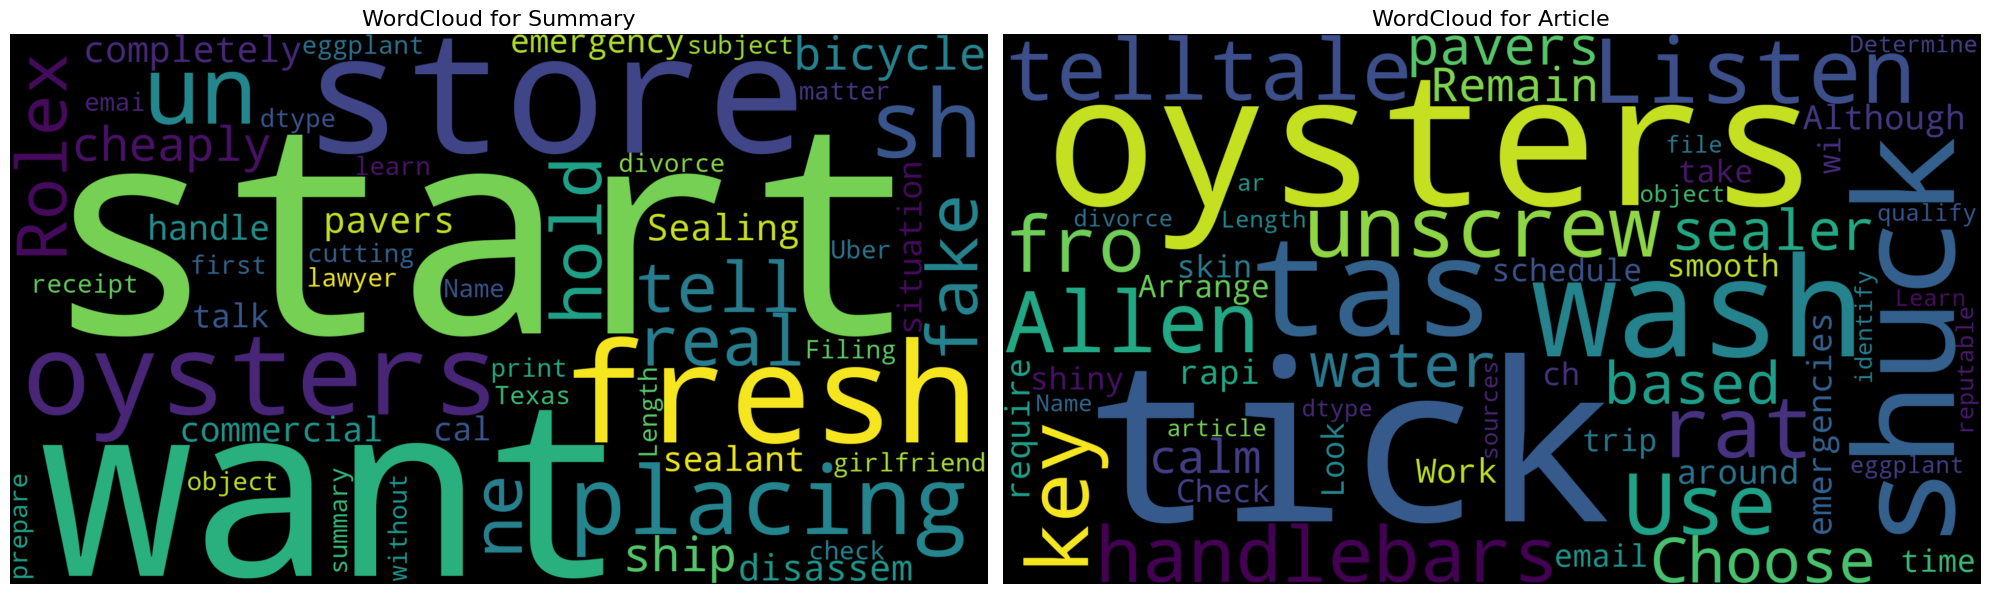

In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
wordcloud_summary = WordCloud(width=1920, height=1080).generate(str(df['summary']))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.title("WordCloud for Summary", fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_article = WordCloud(width=1920, height=1080).generate(str(df['article']))
plt.imshow(wordcloud_article, interpolation='bilinear')
plt.title("WordCloud for Article", fontsize=16)
plt.axis('off')


plt.tight_layout()
plt.show()


In [4]:
df = df.sample(frac=0.1, random_state=42)
df.shape

(3577, 2)

In [5]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    words = text.lower().split()  # Split into words
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return words

df['article'] = df['article'].apply(preprocess)
df['summary'] = df['summary'].apply(preprocess)

In [6]:
max_article=df['article'].str.len().max()
max_summary=df['summary'].str.len().max()
print(max_article)
print(max_summary)

3339
482


In [7]:
# Word2Vec Training
DIM = 100
WINDOW = 10
MIN_COUNT = 1

article_w2v = Word2Vec(sentences=df['article'], vector_size=DIM, window=WINDOW, min_count=MIN_COUNT)
summary_w2v = Word2Vec(sentences=df['summary'], vector_size=DIM, window=WINDOW, min_count=MIN_COUNT)

In [8]:
# Tokenization
max_article_len = 300
max_summary_len = 50

article_tokenizer = Tokenizer()
article_tokenizer.fit_on_texts(df['article'])
article_seq = article_tokenizer.texts_to_sequences(df['article'])
article_seq = pad_sequences(article_seq, maxlen=max_article_len, padding='post')

summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(df['summary'])
summary_seq = summary_tokenizer.texts_to_sequences(df['summary'])
summary_seq = pad_sequences(summary_seq, maxlen=max_summary_len, padding='post')

vocab_size_article = len(article_tokenizer.word_index) + 1
vocab_size_summary = len(summary_tokenizer.word_index) + 1

In [9]:
# Create Embedding Matrices
def get_weight_matrix(model, tokenizer, vocab_size, embedding_dim):
    weight_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size and word in model.wv:
            weight_matrix[i] = model.wv[word]
    return weight_matrix

embedding_matrix_article = get_weight_matrix(article_w2v, article_tokenizer, vocab_size_article, DIM)
embedding_matrix_summary = get_weight_matrix(summary_w2v, summary_tokenizer, vocab_size_summary, DIM)

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_article_len,))
encoder_embedding = Embedding(vocab_size_article, embedding_dim, weights=[embedding_matrix_article], trainable=False)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_outputs = BatchNormalization()(encoder_outputs)

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(vocab_size_summary, embedding_dim, weights=[embedding_matrix_summary], trainable=False)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
decoder_outputs = BatchNormalization()(decoder_outputs)
decoder_dense = Dense(vocab_size_summary, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

# Optimizer
adam = Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 100)  │ 10,595,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 100) │  2,167,600 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    365,568 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    365,568 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 256) │      1,024 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  5,570,732 │ batch_normalizat… │
│                     │ 21676)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,066,292 (72.73 MB)

 Trainable params: 6,302,380 (24.04 MB)

 Non-trainable params: 12,763,912 (48.69 MB)

In [ ]:
decoder_input_seq = summary_seq[:, :-1]
decoder_target_seq = summary_seq[:, 1:]


# Train the Model
history=model.fit(
    [article_seq, decoder_input_seq],
    decoder_target_seq,
    batch_size=128,
    epochs=100,
    validation_split=0.2,
)

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
predictions = model.predict([article_seq, decoder_input_seq])

# Convert predictions to class indices
predicted_indices = predictions.argmax(axis=-1)  # Get the index of the maximum probability for each time step

# Flatten sequences for comparison with target
true_classes = decoder_target_seq.flatten()
predicted_classes = predicted_indices.flatten()

# Filter out padding (assuming padding index is 0)
mask = true_classes != 0
true_classes = true_classes[mask]
predicted_classes = predicted_classes[mask]

# Classification report
report = classification_report(true_classes, predicted_classes, output_dict=True)
print("Classification Report:")
print(report)

# Heatmap for classification report
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.ylabel("Metrics")
plt.xlabel("Classes")
plt.show()

# Optional: Confusion Matrix Display
ConfusionMatrixDisplay.from_predictions(true_classes, predicted_classes, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()